### Adding skip connections to 1-hidden layer

In the following it is analysed how inserting of skip connection can benefit the condition number of the outer product Hessian 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import time
from IPython.display import display, Latex

from torch.distributions.multivariate_normal import MultivariateNormal
from datetime import datetime

In [3]:
torch.set_default_dtype(torch.float64)

In [4]:
# Create model of linear NN with L hidden layers
# input dim = d, hidden dim = m, output dim = k
class Linear_NN(nn.Module):
    def __init__(self,d,m,k,L):
        """
            d: input dimension
            m: hidden layer dimension 
            k: output dimension
            L: number of hidden layers
        """
        super().__init__()
        
        self.L = L
        self.lin_out = nn.Linear(m, k, bias=False)
        self.lin_in = nn.Linear(d, m, bias=False)
        
        self.lin_hidden = nn.ModuleList([nn.Linear(m, m, bias=False) for i in range(self.L)])
        
        
    def forward(self, xb):
        xb = self.lin_in(xb)
        
        for i in range(self.L):
            xb = self.lin_hidden[i](xb)
            
        xb = self.lin_out(xb)
        
        return xb
    
    def init_weights(self, init_type):
        if init_type == 'kaiming_normal':
            torch.nn.init.kaiming_normal_(self.lin_in.weight, nonlinearity='linear')
            torch.nn.init.kaiming_normal_(self.lin_out.weight, nonlinearity='linear')
            for i in range(self.L):
                torch.nn.init.kaiming_normal_(self.lin_hidden[i].weight, nonlinearity='linear')
        elif init_type == 'kaiming_uniform':
            torch.nn.init.kaiming_uniform_(self.lin_in.weight, nonlinearity='linear')
            torch.nn.init.kaiming_uniform_(self.lin_out.weight, nonlinearity='linear')
            for i in range(self.L):
                torch.nn.init.kaiming_uniform_(self.lin_hidden[i].weight, nonlinearity='linear')
        elif init_type == 'xavier_normal':
            torch.nn.init.xavier_normal_(self.lin_in.weight)
            torch.nn.init.xavier_normal_(self.lin_out.weight)
            for i in range(self.L):
                torch.nn.init.xavier_normal_(self.lin_hidden[i].weight)
        elif init_type == 'xavier_uniform':
            torch.nn.init.xavier_uniform_(self.lin_in.weight, nonlinearity='linear')
            torch.nn.init.xavier_uniform_(self.lin_out.weight, nonlinearity='linear')
            for i in range(self.L):
                torch.nn.init.xavier_uniform_(self.lin_hidden[i].weight, nonlinearity='linear')
        else:
            print('Unknown initialization. Using Kaiming normal initialization')
            torch.nn.init.kaiming_normal_(self.lin1.weight, nonlinearity='linear')
            torch.nn.init.kaiming_normal_(self.lin2.weight, nonlinearity='linear')
            for i in range(self.L):
                torch.nn.init.kaiming_normal_(self.lin_hidden[i].weight, nonlinearity='linear')

In [7]:
d = 10 # input dimension
m1 = [50, 60, 80, 100, 500, 1000] # hidden layer dimension
k = 10 # output dimension

L = 0 # number of hidden layers of dim "m"

num_param = [] # count the number of parameters in the model
Linear_Networks = []

# initiate linear networks of given depth L[l] with m1 hidden units each
for l in range(len(m1)):
    Linear_Networks.append(Linear_NN(d,m1[l],k,L))
    num_param.append(sum(p.numel() for p in Linear_NN(d,m1[l],k,L).parameters()))

In [8]:
rep = 2000

beta = 1/(np.sqrt(L+2))
gamma = 1/(np.sqrt(L+2))

H_o_tilde_cond_kaiming_noskip = []
H_o_tilde_cond_kaiming_skip = []

cov_x = torch.eye(d)
# cov_x[-1,-1] = 100

# define multi-variate normal generator with unit matrix as variance
mvrn_d = MultivariateNormal(torch.zeros(d),cov_x)
mvrn_k = MultivariateNormal(torch.zeros(k),torch.eye(k))

# sample n (input,output) tuples
n = 10000
x = mvrn_d.rsample((n,))    
y = mvrn_k.rsample((n,))

# calculate the empirical input covariance matrix and its condition number
cov_xx = x.T @ x / n

cond_cov_xx = np.linalg.cond(cov_xx)

# do the calculations for each l in L
for l in range(len(m1)):
    print('Calculations for m=',m1[l])
    # repeat the calculation at initialization for "rep" times
    H_o_tilde_cond_skip = []
    H_o_tilde_cond_noskip = []
    
    H_o_tilde_cond_l_upper_bound = []
    for i in range(rep):

        if i%1000 == 0:
            print('iter: ', i)

        # initialize the weight matrices according to the defined initialization
        Linear_Networks[l].init_weights('kaiming_normal')
        
        
        V_kaiming = Linear_Networks[l].lin_in.weight
        W_kaiming = Linear_Networks[l].lin_out.weight

        identity_W = torch.eye(W_kaiming.shape[0],W_kaiming.shape[1]) 
        identity_V = torch.eye(V_kaiming.shape[0],V_kaiming.shape[1])
        # calculate the outer Hessian product according to the expression derived by Sidak
        H_o_tilde_noskip = torch.kron(W_kaiming@W_kaiming.T, cov_xx) + torch.kron( torch.eye(k), V_kaiming.T@V_kaiming@cov_xx)

        
        H_o_tilde_skip = torch.kron(( W_kaiming + beta *  identity_W) @ ( W_kaiming + beta * identity_W ).T, cov_xx) + \
                               torch.kron( torch.eye(k), ( V_kaiming + gamma * identity_V ).T @  
                                                          ( V_kaiming + gamma * identity_V ) @ cov_xx)
        H_o_tilde_cond_skip.append(torch.linalg.cond(H_o_tilde_skip.detach()))
        
        H_o_tilde_cond_noskip.append(torch.linalg.cond(H_o_tilde_noskip.detach()))
              
    
    H_o_tilde_cond_kaiming_skip.append(H_o_tilde_cond_skip)
    H_o_tilde_cond_kaiming_noskip.append(H_o_tilde_cond_noskip)
       


Calculations for m= 50
iter:  0
iter:  1000
Calculations for m= 60
iter:  0
iter:  1000
Calculations for m= 80
iter:  0
iter:  1000
Calculations for m= 100
iter:  0
iter:  1000
Calculations for m= 500
iter:  0
iter:  1000
Calculations for m= 1000
iter:  0
iter:  1000


In [9]:
display(Latex(f'Average condition number of the outer product Hessian for $\kappa(\Sigma) \\approx $ 1'))

print('No skip connection')
for l in range(len(m1)):
    display(Latex(f'$\mathbb{{E}}[\kappa(\\tilde{{H}}_{{kai,o,m={m1[l]}}})]={np.mean(H_o_tilde_cond_kaiming_noskip[l])}$'))

print('With skip connection')
for l in range(len(m1)):
    display(Latex(f'$\mathbb{{E}}[\kappa(\\tilde{{H}}_{{kai,o,m={m1[l]}}})]={np.mean(H_o_tilde_cond_kaiming_skip[l])}$'))

<IPython.core.display.Latex object>

No skip connection


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

With skip connection


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Text(0.5, 1.0, 'Condition number of 1-hidden layer NN with and without skip connection.')

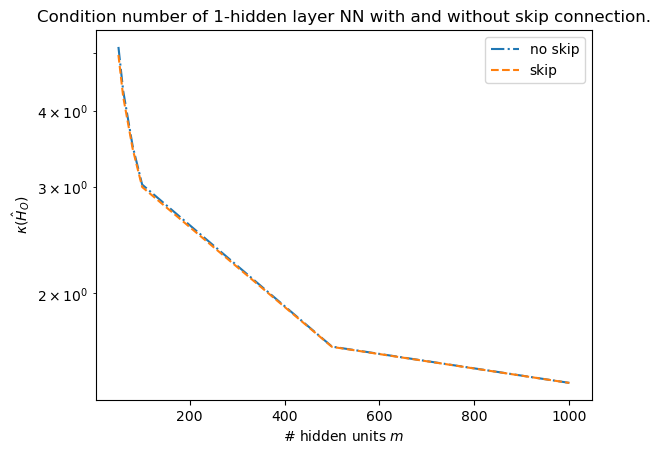

In [10]:
plt.semilogy(m1,[np.mean(H_o_tilde_cond_kaiming_noskip[l]) for l in range(len(m1))],'-.', label='no skip')
plt.semilogy(m1,[np.mean(H_o_tilde_cond_kaiming_skip[l]) for l in range(len(m1))],'--', label = 'skip')

plt.legend()

plt.xlabel(r'# hidden units $m$')
plt.ylabel(r'$\kappa(\hat{H}_O)$')
plt.title('Condition number of 1-hidden layer NN with and without skip connection.')

We can see the benefit of skip connections, but it is relatively marginal with increasing number of hidden units in the 1-hidden layer case. It would be interesting to see how it behaves for increasing number of hidden units. 
Also, it is unable to compensate for badly conditioned input covariance matrices.

In [13]:
## Check the theoretical upper bound for the 1-hidden layer NN without skip connection

t = 3
prob = 1 - 8 * np.exp(-t**2/2)
m = np.array(m1)

kappa_sigma = 1
beta = 1
gamma = 1
epsilon = 0.01

display(Latex(r'Upper bound of outer product Hessian $\textbf{without}$ skip connection with high probability: $p = 1 - 8 \exp(-t^2/2)$'))
display(Latex(f'For $t = {t}$, $p = {prob}$'))


# if np.minimum(np.sqrt(m)-np.sqrt(k)-t,np.sqrt(m)-np.sqrt(d)-t) < 0:
#     print('Invalid choice of t')

# else:

# Kaiming initialization
sigma2_w = 1/m
sigma2_v = 1/d

print(( np.sqrt(m) - np.sqrt(k) - t ))

nominator_summand1 = sigma2_w*(np.sqrt(m)+np.sqrt(k)+t)**2 + sigma2_v*(np.sqrt(m)+np.sqrt(d)+t)**2
# nominator_summand2 = 2*beta*np.sqrt(sigma2_v)*(2*np.sqrt(d)+t) + 2*gamma*np.sqrt(sigma2_w)*(2*np.sqrt(k)+t) + beta**2 + gamma**2
denominator_summand1 = sigma2_w*(np.sqrt(m)-np.sqrt(k)-t)**2 + sigma2_v*(np.sqrt(m)-np.sqrt(d)-t)**2
# denominator_summand2 = 2*beta*np.sqrt(sigma2_v)*epsilon/np.sqrt(d) + 2*gamma*np.sqrt(sigma2_w)*epsilon/np.sqrt(k)
upperbound_noskip = kappa_sigma*(nominator_summand1)/(denominator_summand1)
for i in range(0,len(upperbound_noskip)):
    display(Latex(f'for m={m[i]}, upper bound for Kaiming initialization $\kappa(\hat{{H}}_{{O,Kai,m}}) \leq {upperbound_noskip[i]}$'))
    
    


## Check the theoretical upper bound for the 1-hidden layer NN with skip connection

t = 3
prob = 1 - 8 * np.exp(-t**2/2)
m = np.array(m1)

kappa_sigma = 1
beta = 1
gamma = 1
epsilon = 0.01

display(Latex(r'Upper bound of outer product Hessian $\textbf{with}$ skip connection with high probability: $p = 1 - 8 \exp(-t^2/2)$'))
display(Latex(f'For $t = {t}$, $p = {prob}$'))


# if np.minimum(np.sqrt(m)-np.sqrt(k)-t,np.sqrt(m)-np.sqrt(d)-t) < 0:
#     print('Invalid choice of t')

# else:

# Kaiming initialization
sigma2_w = 1/m
sigma2_v = 1/d

nominator_summand1 = sigma2_w * ( np.sqrt(m) + np.sqrt(k) + t )**2 \
                    + sigma2_v * ( np.sqrt(m) + np.sqrt(d) + t )**2
nominator_summand2 = 2 * beta * np.sqrt(sigma2_v) * (2*np.sqrt(d)+t) \
                    + 2 * gamma * np.sqrt(sigma2_w) * (2 * np.sqrt(k) + t) \
                    + beta**2 + gamma**2
denominator_summand1 = sigma2_w * ( np.sqrt(m) - np.sqrt(k) - t )**2 \
                    + sigma2_v * ( np.sqrt(m) - np.sqrt(d) - t )**2
denominator_summand2 = 2 * beta * np.sqrt(sigma2_v) * epsilon / np.sqrt(d) \
                    + 2 * gamma * np.sqrt(sigma2_w) * epsilon / np.sqrt(k) \
                    + beta**2 + gamma**2
upperbound_skip = kappa_sigma*(nominator_summand1+nominator_summand2)/(denominator_summand1+denominator_summand2)

print(( np.sqrt(m) - np.sqrt(k) - t ))

for i in range(0,len(upperbound_skip)):
    display(Latex(f'for m={m[i]}, upper bound for Kaiming initialization $\kappa(\hat{{H}}_{{O,Kai,m}}) \leq {upperbound_skip[i]}$'))


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

[ 0.90879015  1.58368903  2.78199425  3.83772234 16.19840211 25.46049894]


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

[ 0.90879015  1.58368903  2.78199425  3.83772234 16.19840211 25.46049894]


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Text(0.5, 0, 'hidden units $m$')

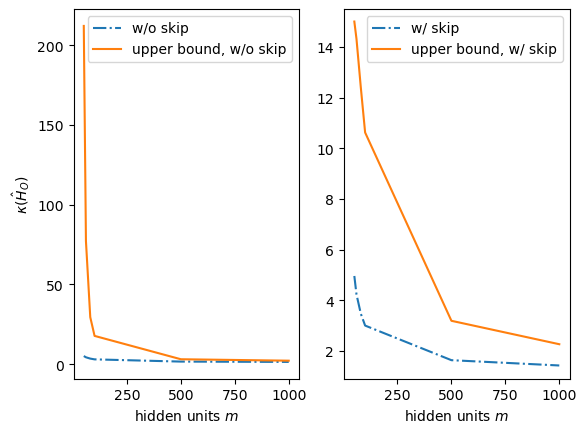

In [14]:
plt.subplot(121)
plt.plot(m1,[np.mean(H_o_tilde_cond_kaiming_noskip[l]) for l in range(len(m1))],'-.', label='w/o skip')
plt.plot(m1,upperbound_noskip, label='upper bound, w/o skip')

# plt.ylim([0.9,15.5])

plt.legend()

plt.ylabel('$\kappa(\hat{H}_O)$')
plt.xlabel('hidden units $m$')

plt.subplot(122)
plt.plot(m1,[np.mean(H_o_tilde_cond_kaiming_skip[l]) for l in range(len(m1))],'-.', label='w/ skip')
plt.plot(m1,upperbound_skip, label='upper bound, w/ skip')
plt.ylim([0.9,15.5])

plt.legend()
plt.xlabel('hidden units $m$')

The upper bound for $\kappa(\hat{H}_O)$ for a 1-hidden layer linear NN is much tighter for few hidden units due to the regularizing effect of the skip connection. However this effect diminishes if we increase the number of hidden units.

### Adding skip connections to L-hidden layers

In the following it is analysed how inserting of skip connection can benefit the condition number of the outer product Hessian for L-hidden layer linear NN.
The skip connection skips exactly one layer and is added for every layer

In [14]:
d = 5 # input dimension
m1 = 20 # hidden layer dimension
k = 6 # output dimension
L = [0,1,2,3,4,5] # number of hidden layers of dim "m"
# L = [30]
num_param = [] # count the number of parameters in the model
Linear_Networks = [] # list of NN with different number of hidden layers

# initiate linear networks of given depth L[l] with m1 hidden units each
for l in range(len(L)):
    Linear_Networks.append(Linear_NN(d,m1,k,L[l]))
    num_param.append(sum(p.numel() for p in Linear_NN(d,m1,k,L[l]).parameters()))

In [26]:
torch.manual_seed(314159265)

rep = 100

H_o_tilde_cond_kaiming_noskip_l = []
H_o_tilde_cond_kaiming_skip_l = []

H_o_cond_upper_bounds_noskip_l = []
H_o_cond_upper_bounds_skip_l = []

cov_x = torch.eye(d)

# define multi-variate normal generator with unit matrix as variance
mvrn_d = MultivariateNormal(torch.zeros(d),cov_x)
mvrn_k = MultivariateNormal(torch.zeros(k),torch.eye(k))

# sample n (input,output) tuples
n = 10000
x = mvrn_d.rsample((n,))    
y = mvrn_k.rsample((n,))

# calculate the empirical input covariance matrix and its condition number
cov_xx = x.T @ x / n

cond_cov_xx = torch.linalg.cond(cov_xx)

# do the calculations for each linear NN
for l in range(len(L)):
    print('#hidden layers:', L[l])
    
    gamma = 20
    beta = 20
    delta = 20
#     gamma = 1/np.sqrt(L[l]+2) #scale factor for layer_in skip connection
#     beta = 1/np.sqrt(L[l]+2) #scale factor for layer_out skip connection
#     delta = 1/np.sqrt(L[l]+2) #scale factor for layer_hidden skip connection

    H_o_tilde_cond_noskip_l = []
    H_o_tilde_cond_skip_l = []
    
    H_o_tilde_cond_l_upper_bound_noskip = []
    H_o_tilde_cond_l_upper_bound_skip = []


    identity_in = torch.eye(Linear_Networks[l].lin_in.weight.shape[0], 
                           Linear_Networks[l].lin_in.weight.shape[1]) 
    identity_out = torch.eye(Linear_Networks[l].lin_out.weight.shape[0],
                           Linear_Networks[l].lin_out.weight.shape[1])
    if L[l] > 0:
        identity_hidden_layer = torch.eye(Linear_Networks[l].lin_hidden[0].weight.shape[0],
                                          Linear_Networks[l].lin_hidden[0].weight.shape[1])
    
    for i in range(rep):

        if i%1000 == 0:
            print('iter:', i)

        # initialize the weight matrices according to the defined initialization
        Linear_Networks[l].init_weights('kaiming_normal')


    ## calculate the condition number w/o skip connection
        UT_U_noskip_l = torch.zeros((k*d,k*d))
        
        if L[l] == 0:
            V_kaiming = Linear_Networks[l].lin_in.weight.detach()
            W_kaiming = Linear_Networks[l].lin_out.weight.detach()


            # calculate the outer Hessian product according to the expression derived by Sidak
            H_o_tilde_noskip_l = torch.kron(W_kaiming@W_kaiming.T, cov_xx) + torch.kron( torch.eye(k), V_kaiming.T@V_kaiming@cov_xx)
            H_o_tilde_cond_noskip_l.append(torch.linalg.cond(H_o_tilde_noskip_l))
        

        
        else: 
            for j in range(1,L[l]+2+1):
                if j == L[l]+2:
                    fac1 = torch.eye(k)
                else:
                    fac1 = Linear_Networks[l].lin_out.weight.detach()
                    
                    for lay in range(-1,-2-L[l]+j,-1):
                        fac1 = fac1 @ Linear_Networks[l].lin_hidden[lay].weight.detach()

                fac1 = fac1 @ fac1.T

                if j == 1:
                    fac2 = torch.eye(d)
                else:
                    fac2 = Linear_Networks[l].lin_in.weight.detach().T

                    for lay in range(j-2):
                        fac2 = fac2 @ Linear_Networks[l].lin_hidden[lay].weight.detach().T

                fac2 = fac2 @ fac2.T

                UT_U_noskip_l += torch.kron(fac1,fac2)



            # calculate the outer Hessian product according to the expression derived by Sidak
            H_o_tilde_noskip_l = UT_U_noskip_l @ (torch.kron(torch.eye(k), cov_xx))
            H_o_tilde_cond_noskip_l.append(torch.linalg.cond(H_o_tilde_noskip_l))
            
            
    # calculate the theoretical upper bound of the condition number of outer product Hessian w/o skip connection
    # based on the first approximation Eq. (56/57)
        lam_max_upperb = 0
        lam_min_lowerb = 0
        
        for el in range(1,L[l]+2+1):
            if el == L[l]+2:
                W_1 = torch.eye(k) 
            else:
                W_1 = Linear_Networks[l].lin_out.weight.detach()
            
                for lay in range(-1,-2-L[l]+el,-1):
                    W_1 = W_1 @ Linear_Networks[l].lin_hidden[lay].weight.detach()
            
            if el == 1:
                W_2 = torch.eye(d)
            else:
                W_2 = Linear_Networks[l].lin_in.weight.detach().T
                
                for lay in range(el-2):
                    W_2 = W_2 @ Linear_Networks[l].lin_hidden[lay].weight.detach().T
            
            lam_max_upperb += torch.linalg.eigvalsh(W_1 @ W_1.T)[-1] * torch.linalg.eigvalsh(W_2 @ W_2.T)[-1]
            lam_min_lowerb += torch.linalg.eigvalsh(W_1 @ W_1.T)[0] * torch.linalg.eigvalsh(W_2 @ W_2.T)[0]            
            
        H_o_tilde_upper_b_noskip = ((lam_max_upperb)/(lam_min_lowerb)) * cond_cov_xx
        H_o_tilde_cond_l_upper_bound_noskip.append(H_o_tilde_upper_b_noskip) 


# 
        
# #         # calculate the theoretical upper bound of the condition number of outer product Hessian
# #         H_o_tilde_upper_b = ( (torch.linalg.svdvals( Linear_Networks[l].lin_in.weight.detach() )[0] + beta)**2 * \
# #                              (torch.linalg.svdvals( Linear_Networks[l].lin_out.weight.detach() )[0] + gamma)**2 
# #                             ) / \
# #                             ( (torch.linalg.svdvals( Linear_Networks[l].lin_in.weight.detach() )[-1] + beta)**2 * \
# #                              (torch.linalg.svdvals( Linear_Networks[l].lin_out.weight.detach() )[-1] + gamma)**2 
# #                             )
        
# #         nominator = (1/(torch.linalg.svdvals( Linear_Networks[l].lin_in.weight.detach() )[0] + beta)**2) \
# #                     + (1/(torch.linalg.svdvals( Linear_Networks[l].lin_out.weight.detach() )[0] + gamma)**2)
# #         denominator = (1/(torch.linalg.svdvals( Linear_Networks[l].lin_in.weight.detach() )[-1] + beta)**2) \
# #                     + (1/(torch.linalg.svdvals( Linear_Networks[l].lin_out.weight.detach() )[-1] + gamma)**2)
       
# #         for lay in range(L[l]):
# #             H_o_tilde_upper_b *= ( (torch.linalg.svdvals( Linear_Networks[l].lin_hidden[lay].weight.detach() )[0] + delta)**2 ) \
# #                                     / \
# #                                  ( (torch.linalg.svdvals( Linear_Networks[l].lin_hidden[lay].weight.detach() )[min(d,k)+2] + delta)**2 )
            
            
# #             nominator += ( torch.linalg.svdvals(Linear_Networks[l].lin_hidden[lay].weight.detach())[0] + delta )**2
# #             denominator += ( torch.linalg.svdvals(Linear_Networks[l].lin_hidden[lay].weight.detach())[min(d,k)+2] + delta )**2
            
            
# #         H_o_tilde_upper_b *= ((nominator)/(denominator)) * cond_cov_xx
# #         H_o_tilde_cond_l_upper_bound_skip.append(H_o_tilde_upper_b)


    ## calculate the condition number w/ skip connection        
        UT_U_skip_l = torch.zeros((k*d,k*d))
        
        if L[l] == 0:
            V_kaiming = Linear_Networks[l].lin_in.weight.detach()
            W_kaiming = Linear_Networks[l].lin_out.weight.detach()


            # calculate the outer Hessian product according to the expression derived by Sidak
            H_o_tilde_skip_l = torch.kron(( W_kaiming + beta *  identity_out) @ ( W_kaiming + beta * identity_out ).T, cov_xx) + \
                           torch.kron( torch.eye(k), ( V_kaiming + gamma * identity_in ).T @  
                                                      ( V_kaiming + gamma * identity_in ) @ cov_xx)
            H_o_tilde_cond_skip_l.append(torch.linalg.cond(H_o_tilde_skip_l))
        
        else:
            for j in range(1,L[l]+2+1):
                if j == L[l]+2:
                    fac1 = torch.eye(k,) 
                else:
                    fac1 = (Linear_Networks[l].lin_out.weight.detach() + beta *  identity_out)

                    for lay in range(-1,-2-L[l]+j,-1):
                        fac1 = fac1 @ (Linear_Networks[l].lin_hidden[lay].weight.detach() + delta * identity_hidden_layer)

                fac1 = fac1 @ fac1.T

                if j == 1:
                    fac2 = torch.eye(d)
                else:
                    fac2 = (Linear_Networks[l].lin_in.weight.detach() + gamma * identity_in).T

                    for lay in range(j-2):
                        fac2 = fac2 @ (Linear_Networks[l].lin_hidden[lay].weight.detach() + delta * identity_hidden_layer).T 

                fac2 = fac2 @ fac2.T

                UT_U_skip_l += torch.kron(fac1,fac2)



            # calculate the outer Hessian product according to the expression derived by Sidak
            H_o_tilde_skip_l = UT_U_skip_l @ (torch.kron(torch.eye(k), cov_xx))
            H_o_tilde_cond_skip_l.append(torch.linalg.cond(H_o_tilde_skip_l))
            
    # calculate the theoretical upper bound of the condition number of outer product Hessian w/o skip connection
    # based on the first approximation Eq. (56/57)
        lam_max_upperb = 0
        lam_min_lowerb = 0
        
        for el in range(1,L[l]+2+1):
            if el == L[l]+2:
                W_1 = torch.eye(k) 
            else:
                W_1 = (Linear_Networks[l].lin_out.weight.detach() + beta *  identity_out)
            
                for lay in range(-1,-2-L[l]+el,-1):
                    W_1 = W_1 @ (Linear_Networks[l].lin_hidden[lay].weight.detach() + delta * identity_hidden_layer)
            
            if el == 1:
                W_2 = torch.eye(d)
            else:
                W_2 = (Linear_Networks[l].lin_in.weight.detach() + gamma * identity_in).T
                
                for lay in range(el-2):
                    W_2 = W_2 @ (Linear_Networks[l].lin_hidden[lay].weight.detach() + delta * identity_hidden_layer).T
            
            lam_max_upperb += torch.linalg.eigvalsh(W_1 @ W_1.T)[-1] * torch.linalg.eigvalsh(W_2 @ W_2.T)[-1]
            lam_min_lowerb += torch.linalg.eigvalsh(W_1 @ W_1.T)[0] * torch.linalg.eigvalsh(W_2 @ W_2.T)[0]            
            
        H_o_tilde_upper_b_skip = ((lam_max_upperb)/(lam_min_lowerb)) * cond_cov_xx
        H_o_tilde_cond_l_upper_bound_skip.append(H_o_tilde_upper_b_skip)
      
    
    H_o_tilde_cond_kaiming_noskip_l.append(H_o_tilde_cond_noskip_l)
    H_o_tilde_cond_kaiming_skip_l.append(H_o_tilde_cond_skip_l)
    
    H_o_cond_upper_bounds_skip_l.append(H_o_tilde_cond_l_upper_bound_skip)
    H_o_cond_upper_bounds_noskip_l.append(H_o_tilde_cond_l_upper_bound_noskip)


       


#hidden layers: 0
iter: 0
#hidden layers: 1
iter: 0
#hidden layers: 2
iter: 0
#hidden layers: 3
iter: 0
#hidden layers: 4
iter: 0
#hidden layers: 5
iter: 0


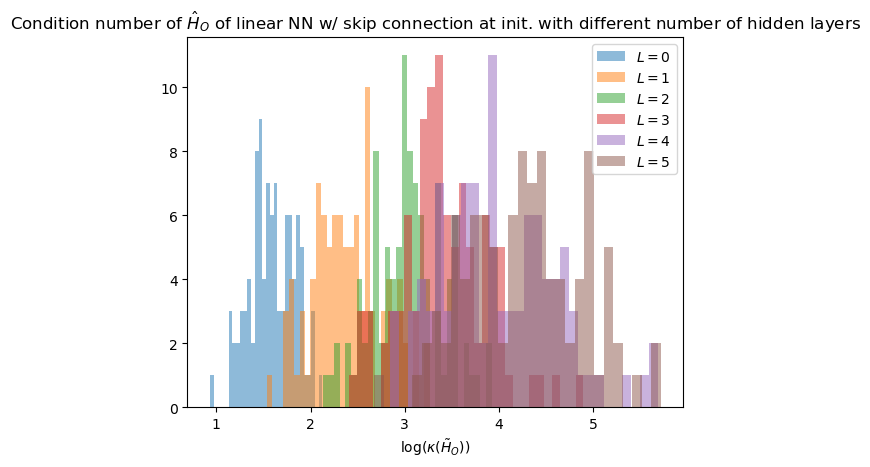

In [21]:
for i,l in enumerate(L):
    plt.hist(np.log(H_o_tilde_cond_kaiming_skip_l[i]), alpha=0.5, bins=30, label='$L= %d$' % l)

plt.xlabel(f'$\\log(\kappa(\\tilde{{H}}_O))$')
plt.title(f'Condition number of $\hat{{H}}_O$ of linear NN w/ skip connection at init. with different number of hidden layers')
plt.legend()

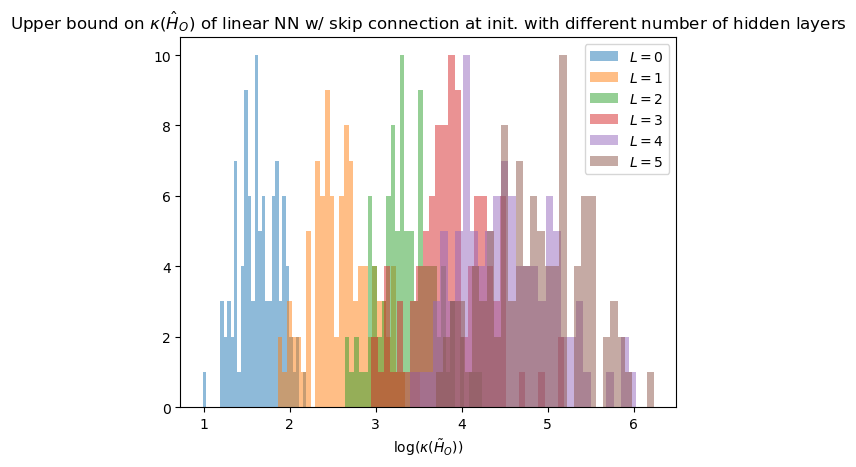

In [22]:
for i,l in enumerate(L):
    plt.hist(np.log(H_o_cond_upper_bounds_skip_l[i]), alpha=0.5, bins=30, label='$L= %d$' % l)

plt.xlabel(f'$\\log(\kappa(\\tilde{{H}}_O))$')
plt.title(f'Upper bound on $\kappa(\hat{{H}}_O)$ of linear NN w/ skip connection at init. with different number of hidden layers')
plt.legend()

Text(0.5, 1.0, 'Condition number of L-hidden layer NN with and without skip connection for fixed number of hidden units.')

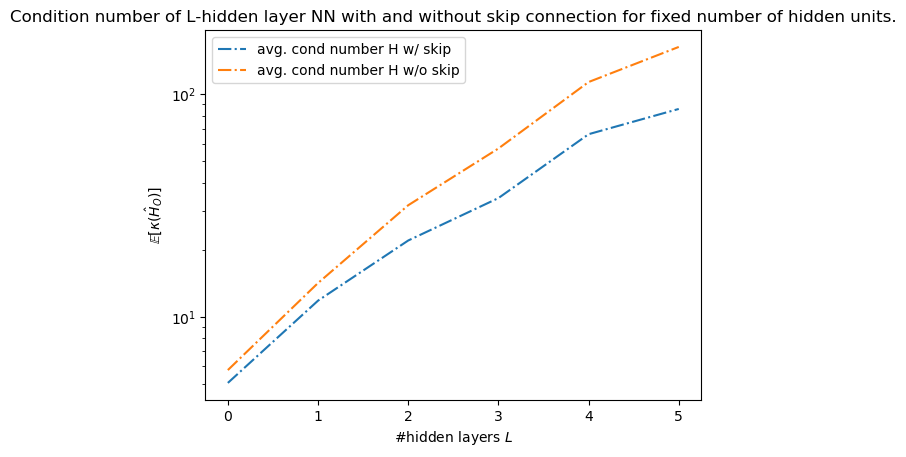

In [23]:
mean_upper_bound_skip = [(np.mean(H_o_cond_upper_bounds_skip_l[i])) for i in range(len(L))]
mean_H_o_tilde_cond_skip = [(np.mean(H_o_tilde_cond_kaiming_skip_l[i])) for i in range(len(L))]

mean_upper_bound_noskip = [(np.mean(H_o_cond_upper_bounds_noskip_l[i])) for i in range(len(L))]
mean_H_o_tilde_cond_noskip = [(np.mean(H_o_tilde_cond_kaiming_noskip_l[i])) for i in range(len(L))]


# plt.semilogy(L, mean_upper_bound_skip, '-', label='avg. upper bound w/ skip')
plt.semilogy(L, mean_H_o_tilde_cond_skip, '-.', label='avg. cond number H w/ skip')

# plt.semilogy(L, mean_upper_bound_noskip, '-', label='avg. upper bound w/o skip')
plt.semilogy(L, mean_H_o_tilde_cond_noskip, '-.', label='avg. cond number H w/o skip')
plt.legend()
plt.ylabel(r'$\log(\kappa(\hat{H}_O))$')
plt.xlabel('#hidden layers $L$')

plt.ylabel(r'$\mathbb{E}[\kappa(\hat{H}_O)]$')

plt.title('Condition number of L-hidden layer NN with and without skip connection for fixed number of hidden units.')


Text(0.5, 1.0, 'Condition number of L-hidden layer NN with and without skip connection for fixed number of hidden units.')

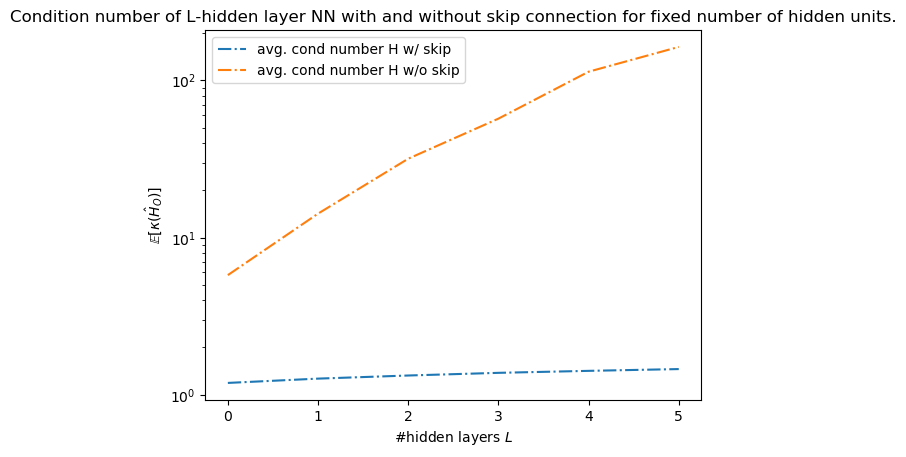

In [27]:
mean_upper_bound_skip = [(np.mean(H_o_cond_upper_bounds_skip_l[i])) for i in range(len(L))]
mean_H_o_tilde_cond_skip = [(np.mean(H_o_tilde_cond_kaiming_skip_l[i])) for i in range(len(L))]

mean_upper_bound_noskip = [(np.mean(H_o_cond_upper_bounds_noskip_l[i])) for i in range(len(L))]
mean_H_o_tilde_cond_noskip = [(np.mean(H_o_tilde_cond_kaiming_noskip_l[i])) for i in range(len(L))]


# plt.semilogy(L, mean_upper_bound_skip, '-', label='avg. upper bound w/ skip')
plt.semilogy(L, mean_H_o_tilde_cond_skip, '-.', label='avg. cond number H w/ skip')

# plt.semilogy(L, mean_upper_bound_noskip, '-', label='avg. upper bound w/o skip')
plt.semilogy(L, mean_H_o_tilde_cond_noskip, '-.', label='avg. cond number H w/o skip')
plt.legend()
plt.ylabel(r'$\log(\kappa(\hat{H}_O))$')
plt.xlabel('#hidden layers $L$')

plt.ylabel(r'$\mathbb{E}[\kappa(\hat{H}_O)]$')

plt.title('Condition number of L-hidden layer NN with and without skip connection for fixed number of hidden units.')


(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([-0.28359781, -0.00472097,  0.27415588,  0.55303272,  0.83190956,
         1.1107864 ,  1.38966324,  1.66854008,  1.94741692,  2.22629376,
         2.5051706 ]),
 <BarContainer object of 10 artists>)

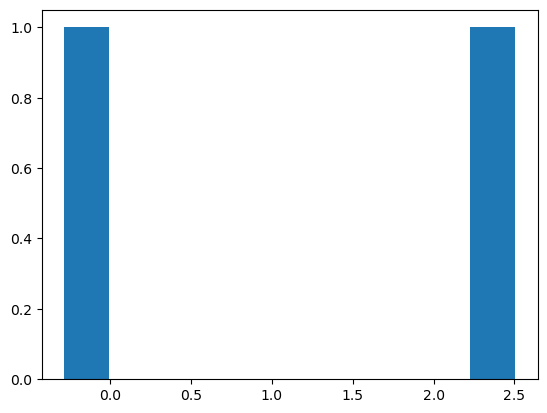

In [33]:
plt.hist(np.array(H_o_tilde_cond_kaiming_noskip_l[1]) - np.array(H_o_tilde_cond_kaiming_skip_l[1]))

In [28]:
display(Latex(r'Average condition number of the outer product Hessian $\textbf{without}$ skip connection for different number of hidden layers:'))

for i in range(len(L)):
    display(Latex(f'$\mathbb{{E}}[\kappa(\\tilde{{H}}_{{kai,o,L={L[i]}}})]={np.mean(H_o_tilde_cond_kaiming_noskip_l[i])}$'))


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [22]:
display(Latex(r'Average upper bound of condition number of the outer product Hessian $\textbf{without}$ skip connection with scaling $1/\sqrt{L}$ for different number of hidden layers:'))

for i in range(len(L)):
    display(Latex(f'$\mathbb{{E}}[\kappa(\\tilde{{H}}_{{kai,o,L={L[i]}}})] \leq {np.mean(H_o_cond_upper_bounds_noskip_l[i])}$'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [75]:
display(Latex(r'Average condition number of the outer product Hessian $\textbf{with}$ skip connection with scaling $1/\sqrt{L}$ for different number of hidden layers:'))

for i in range(len(L)):
    display(Latex(f'$\mathbb{{E}}[\kappa(\\tilde{{H}}_{{kai,o,L = {L[i]}}})]={np.mean(H_o_tilde_cond_kaiming_skip_l[i])}$'))



<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [76]:
display(Latex(r'Average upper bound of condition number of the outer product Hessian $\textbf{with}$ skip connection with scaling $1/\sqrt{L}$ for different number of hidden layers:'))

for i in range(len(L)):
    display(Latex(f'$\mathbb{{E}}[\kappa(\\tilde{{H}}_{{kai,o,L={L[i]}}})] \leq {np.mean(H_o_cond_upper_bounds_skip_l[i])}$'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

#### Observe that the condition number increases much slower with increasing number of hidden layers

Text(0.5, 1.0, 'Ratio of condition number of L-hidden layer NN with and without skip connection for fixed number of hidden units.')

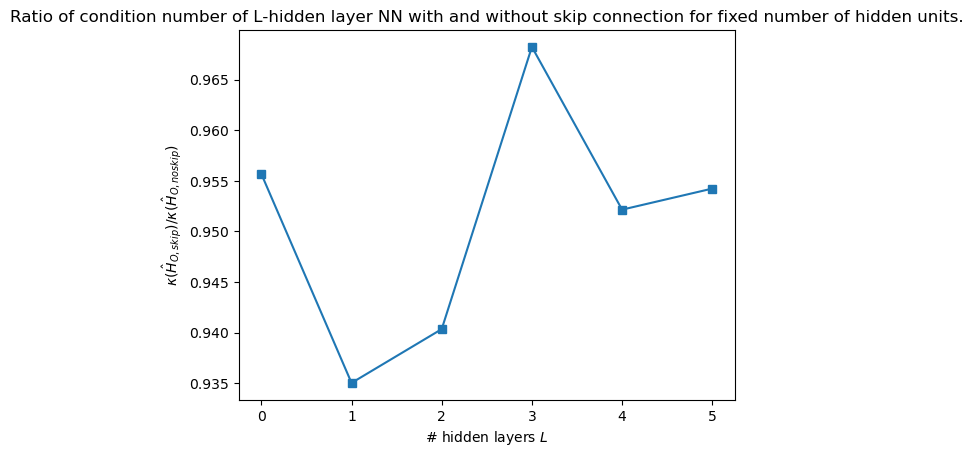

In [77]:
H_cond_noskips = np.array([np.mean(H_o_tilde_cond_kaiming_noskip_l[l]) for l in range(len(L))])
H_cond_skips = np.array([np.mean(H_o_tilde_cond_kaiming_skip_l[l]) for l in range(len(L))])

plt.plot(L, H_cond_skips/H_cond_noskips, 's-')

plt.xlabel(r'# hidden layers $L$')
plt.ylabel(r'$\kappa(\hat{H}_{O,skip}) / \kappa(\hat{H}_{O,noskip})$')
plt.title('Ratio of condition number of L-hidden layer NN with and without skip connection for fixed number of hidden units.')